## Prerequisites

In [ ]:
!pip install gym-retro
!pip install gym[atari]

In [ ]:
!pip install gym==0.21.0

In [ ]:
!wget http://www.atarimania.com/roms/Roms.rar

In [ ]:
!unrar x Roms.rar

In [ ]:
!python -m retro.import mspacman-roms/

## Import Library and Classes

In [1]:
import time
import retro
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

%matplotlib inline

In [2]:
from dqn_agent import DQNAgent
from dqn_cnn import DQNCnn
from stack_frame import preprocess_frame, stack_frame

## Setup Environment

In [3]:
env = retro.make(game='MsPacMan-Atari2600')
env.seed(0)

[0, 592379725]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## View Environment

In [5]:
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())

The size of frame is:  (210, 160, 3)
No. of Actions:  8


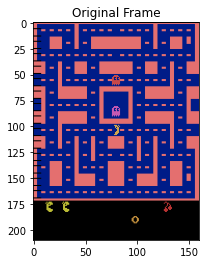

In [6]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

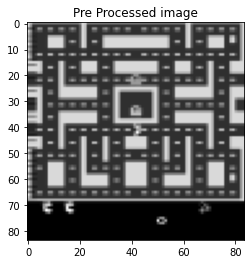

In [7]:
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (1, -1, -1, 1), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

In [8]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (1, -1, -1, 1), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames

In [9]:
def random_play():
    score = 0
    env.reset()
    for i in range(2000):
        env.render()
        action = possible_actions[np.random.randint(len(possible_actions))]
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            print("Your Score at end of game is: ", score)
            break
    env.reset()
    env.render(close=True)
random_play()

C:\Users\WIN\Anaconda3\envs\RL\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Your Score at end of game is:  230.0


## Setup Agent and Hyperparameters

In [10]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = len(possible_actions)
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 32        # Update batch size
LR = 0.0001            # learning rate 
TAU = 1e-3             # for soft update of target parameters
UPDATE_EVERY = 10     # how often to update the network
UPDATE_TARGET = 1000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 1500        # Rate by which epsilon to be decayed
LOAD = False            # load model

agent = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, 
                 GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn, LOAD)

In [11]:
env.viewer = None
# watch an untrained agent
state = stack_frames(None, env.reset(), True) 
for j in range(2000):
    env.render(close=False)
    action = agent.act(state, eps=0.01)
    next_state, reward, done, _ = env.step(possible_actions[action])
    state = stack_frames(state, next_state, False)
    if done:
        env.reset()
        break
env.render(close=True)

## Train Agent with DQN

In [12]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

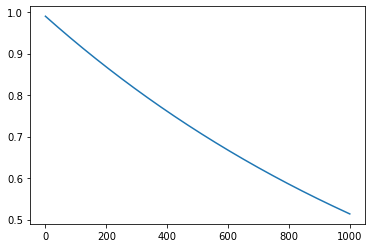

In [13]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

In [14]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    env.viewer = None
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)

        # Punish the agent for not moving forward
        prev_state = {}
        steps_stuck = 0
        timestamp = 0

        while timestamp < 10000:
            env.render(close = False)
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(possible_actions[action])
            #print(info)
            score += reward

            timestamp += 1

            # Punish the agent for standing still for too long.
            if (prev_state == info):
                steps_stuck += 1
            else:
                steps_stuck = 0
            prev_state = info
    
            if (steps_stuck > 20):
                reward -= 1
            
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps), end="")
    
    return scores

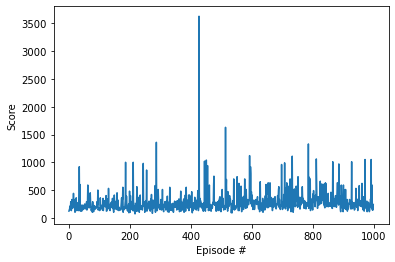

Episode 1000	Average Score: 263.00	Epsilon: 0.75

In [15]:
scores = train(1000)

In [20]:
env.reset()
env.render(close = True)

## Testing Phase

In [19]:
env.viewer = None
# watch a trained agent
state = stack_frames(None, env.reset(), True) 
for j in range(10000):
    env.render(close=False)
    action = agent.act(state, eps=0.5)
    next_state, reward, done, _ = env.step(possible_actions[action])
    state = stack_frames(state, next_state, False)
    if done:
        #env.reset()
        break 
#env.render(close=True)